In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('gutenberg')

import warnings
warnings.filterwarnings('ignore')

c:\users\cmiller\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\cmiller\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cmiller\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Cmiller\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
#reading in the data, this time in the form of paragraphs
emma = gutenberg.paras('austen-emma.txt')

#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, 
                             # drop words that occur in more than half the paragraphs
                             min_df=2, 
                             # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True,
                             #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,
                             #we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', 
                             #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True 
                             #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
#print(emma_paras_tfidf)
print(emma_paras_tfidf.get_shape)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)
#print(X_train_tfidf)
#print(list(zip(*X_train_tfidf_csr.nonzero())))

#Reshapes the vectorizer output into something people can read 
#this step didn't do anything / already in compressed sparse row format
X_train_tfidf_csr = X_train_tfidf.tocsr()
#print(type(X_train_tfidf_csr))
#print(X_train_tfidf_csr[1,1610])

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for i in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()
#print(terms[1502])

# Gives indices for the feature names
vocab = vectorizer.vocabulary_
#print(vocab)

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])
print(X_train_tfidf.shape)

<bound method spmatrix.get_shape of <2371x1948 sparse matrix of type '<class 'numpy.float64'>'
	with 16742 stored elements in Compressed Sparse Row format>>
Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}
(1422, 1948)


The tfidf vectorizer returns a compressed sparsed row matrix containing the row, column (paragraph, word) and tf-idf score.  The for loop creates a dictionary for each paragraph containing the features left from the tf-idf transform and the score of the tf-idf.

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379??(1948) to 130. Then normalize data
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)
print(X_train_lsa.shape)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
#print(paras_by_component.head())
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.1988061726612
(1422, 130)
Component 0:
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
Oh !       0.999288
" Oh !     0.999288
" Oh !"    0.999288
" Oh !     0.999288
" Oh !     0.999288
" Oh !     0.999288
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634273
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.587266
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.564303
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Sm

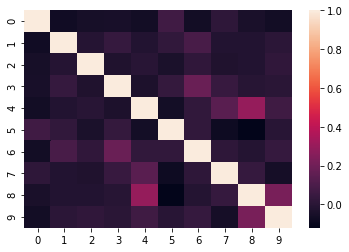

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [5]:
# Compute document similarity using LSA components - Gram Matrix
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

#Only taking the first 10 sentences
sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[0:10,0:10]

#Making a plot
ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

# Drill 1: Test Set
### Apply the Latent Semantic Analysis to the test set

In [14]:
# reduce the test set dimensions to 130 features and normalize
X_test_lsa = lsa.transform(X_test_tfidf)

test_paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
#print(paras_by_component.head())
for i in range(5):
    print('Component {}:'.format(i))
    print(test_paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Me ! oh !    0.999288
" Oh !         0.999288
" Oh !         0.999288
" Oh !         0.999288
" Oh !         0.999288
" Oh !         0.999288
" Oh !         0.999288
" Oh !         0.999288
" Oh no !      0.999288
" Oh !         0.999288
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.674963
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . Weston was wan

After reducing the dimensions of the test set, we can see that the model still identifies similar sentences for the test set.  The first component still likes 'OH', second: both identify sentences with Mrs. Weston and Mr. Knightley, third is chapters (different ones - not sure how there are duplicate chapters...), forth: 'AH', and fifth: the name Emma shows up consistently - short sentences about Emma.

# Drill 1: Tweaking tf-idf

In [15]:
# Change min_df to 5 - only keep words that appear at least 5 times
vec1 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                       min_df=5, # only use words that appear at least twice
                       stop_words='english', 
                       lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                       use_idf=True, #we definitely want to use inverse document frequencies in our weighting
                       norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                       smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
emma_5 = vec1.fit_transform(emma_paras)

print("Number of features: %d" % emma_5.get_shape()[1])

#splitting into training and test sets
X_train_tfidf_5, X_test_tfidf_5 = train_test_split(emma_5, test_size=0.4, random_state=0)

svd1 = TruncatedSVD(130)
lsa1 = make_pipeline(svd1, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa_5 = lsa1.fit_transform(X_train_tfidf_5)

variance_explained_5 = svd1.explained_variance_ratio_
total_variance_5 = variance_explained_5.sum()
print("Percent variance captured by all components with min_df=5:",total_variance_5*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component_5 = pd.DataFrame(X_train_lsa_5, index=X_train)

for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component_5.loc[:,i].sort_values(ascending=False)[0:10])

Number of features: 799
Percent variance captured by all components with min_df=5: 55.88850016622359
Component 0:
" Oh !     0.999071
" Oh !"    0.999071
" Oh !     0.999071
" Oh !     0.999071
" Oh !"    0.999071
" Oh !     0.999071
" Oh !     0.999071
" Oh !     0.999071
" Oh !     0.999071
" Oh !     0.999071
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Name: 1, dtype: float64
Component 2:
CHAPTER IX      1.0
CHAPTER I       1.0
CHAPTER V       1.0
CHAPTER XVI     1.0
CHAPTER XI      1.0
CHAPTER XVII    1.0
CHAPTER VI      1.0
CHAPTER X       1.0
CHAPTER VIII    1.0
CHAPTER I       1.0
Name: 2, dtype: float64
Component 3:
Emma could not resist .                                                        0.673667
" Are you well , my Emma ?"                                                    0.673667
Emma demurred .                                                                0.673667
Emma was silenced .                                                            0.673667
" For shame , Emma !                                                           0.673667
At first it was downright dulness to Emma .                                    0.673667
Emma was most sincerely interested .                                           0.625202
" Emma , my dear Emma "                                                        0.601415
" There were misunders

components 4 and 5 seemed to have changed after adjusting the min_df to 5. HOW IS THE VARIANCE EXPLAINED NOT CHANGING AT ALL?

In [16]:
# Max_Features added = 1000, no stop_words, and stripping accents if there are any
vec2 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                       min_df=2, # only use words that appear at least twice
                       stop_words=None, 
                       strip_accents='unicode', # removes accents 
                       lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                       use_idf=True, #we definitely want to use inverse document frequencies in our weighting
                       max_features=1000, #keeps the top 1000 features (since we are including stop words)
                       norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                       smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
emma_vec2 = vec2.fit_transform(emma_paras)

print("Number of features: %d" % emma_vec2.get_shape()[1])

#splitting into training and test sets
X_train_tfidf_vec2, X_test_tfidf_vec2 = train_test_split(emma_vec2, test_size=0.4, random_state=0)

svd2 = TruncatedSVD(130)
lsa2 = make_pipeline(svd2, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa_vec2 = lsa2.fit_transform(X_train_tfidf_vec2)

variance_explained_vec2 = svd2.explained_variance_ratio_
total_variance_vec2 = variance_explained_vec2.sum()
print("Percent variance captured by all components with vec2:",total_variance_vec2*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component_vec2 = pd.DataFrame(X_train_lsa_vec2, index=X_train)

for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component_vec2.loc[:,i].sort_values(ascending=False)[0:10])

Number of features: 1000
Percent variance captured by all components with vec2: 59.015239978872835
Component 0:
Mrs . Weston was acting no part , feigning no feelings in all that she said to him in favour of the event . She had been extremely surprized , never more so , than when Emma first opened the affair to her ; but she saw in it only increase of happiness to all , and had no scruple in urging him to the utmost . She had such a regard for Mr . Knightley , as to think he deserved even her dearest Emma ; and it was in every respect so proper , suitable , and unexceptionable a connexion , and in one respect , one point of the highest importance , so peculiarly eligible , so singularly fortunate , that now it seemed as if Emma could not safely have attached herself to any other creature , and that she had herself been the stupidest of beings in not having thought of it , and wished it long ago . How very few of those men in a rank of life to address Emma would have renounced their own

Name: 0, dtype: float64
Component 1:
" Oh !     0.999247
" Oh !"    0.999247
" Oh !     0.999247
" Oh !"    0.999247
" Oh !"    0.999247
" Oh !     0.999247
" Oh !     0.999247
" Oh !     0.999247
" Oh !     0.999247
" Oh !"    0.999247
Name: 1, dtype: float64
Component 2:
CHAPTER XVII    1.0
CHAPTER XI      1.0
CHAPTER XII     1.0
CHAPTER V       1.0
CHAPTER III     1.0
CHAPTER IX      1.0
CHAPTER VI      1.0
CHAPTER VIII    1.0
CHAPTER V       1.0
CHAPTER XVI     1.0
Name: 2, dtype: float64
Component 3:
" You will not ask me what is the point of envy . You are determined , I see , to have no curiosity . You are wise  but _I_ cannot be wise .                                                                                  0.509204
" Indeed you injure me if you suppose me unconvinced .                                                                                                                                                                        0.502242
" He appears rough to you ,

Quite different this time.  The "OH" and chapters were still part of the components but in different locations and athe other three seem completely different.

In [17]:
# Change svd to 50
vec3 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                       min_df=2, # only use words that appear at least twice
                       stop_words=None, 
                       strip_accents='unicode', # removes accents 
                       lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                       use_idf=True, #we definitely want to use inverse document frequencies in our weighting
                       max_features=1000, #keeps the top 1000 features (since we are including stop words)
                       norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                       smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
emma_vec3 = vec3.fit_transform(emma_paras)

print("Number of features: %d" % emma_vec3.get_shape()[1])

#splitting into training and test sets
X_train_tfidf_vec3, X_test_tfidf_vec3 = train_test_split(emma_vec3, test_size=0.4, random_state=0)

svd3 = TruncatedSVD(50)
lsa3 = make_pipeline(svd3, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa_vec3 = lsa3.fit_transform(X_train_tfidf_vec3)

variance_explained_vec3 = svd3.explained_variance_ratio_
total_variance_vec3 = variance_explained_vec3.sum()
print("Percent variance captured by all components with vec3:",total_variance_vec3*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component_vec3 = pd.DataFrame(X_train_lsa_vec3, index=X_train)

for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component_vec3.loc[:,i].sort_values(ascending=False)[0:10])

Number of features: 1000
Percent variance captured by all components with vec3: 37.96449737689616
Component 0:
This was the amount of the whole story , of his communication and of Harriet ' s as soon as she had recovered her senses and speech . He dared not stay longer than to see her well ; these several delays left him not another minute to lose ; and Emma engaging to give assurance of her safety to Mrs . Goddard , and notice of there being such a set of people in the neighbourhood to Mr . Knightley , he set off , with all the grateful blessings that she could utter for her friend and herself .                                                                                                                                                                                                                                                                                                                                                                                                             

Name: 0, dtype: float64
Component 1:
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
" Oh !    0.999328
Name: 1, dtype: float64
Component 2:
CHAPTER IV     1.0
CHAPTER II     1.0
CHAPTER X      1.0
CHAPTER VII    1.0
CHAPTER X      1.0
CHAPTER V      1.0
CHAPTER XIV    1.0
CHAPTER XVI    1.0
CHAPTER IX     1.0
CHAPTER XVI    1.0
Name: 2, dtype: float64
Component 3:
" I shall not scold you .                                                                                                                                               0.599041
" You have some news to hear , now you are come back , that will rather surprize you ."                                                                                 0.594501
" You will not ask me what is the point of envy . You are determined , I see , to have no curiosity . You are wise  but _I_ cannot be wise .               

In [28]:
# Max_Features added = 1000, INCLUDE stop_words, and stripping accents if there are any
vec4 = TfidfVectorizer(max_df=0.25, # drop words that occur in more than 25% the paragraphs
                       min_df=1, # only use words that appear at least twice
                       stop_words='english', 
                       strip_accents='unicode', # removes accents 
                       lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                       use_idf=True, #we definitely want to use inverse document frequencies in our weighting
                       max_features=200, #keeps the top 1000 features (since we are including stop words)
                       norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                       smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Applying the vectorizer
emma_vec4 = vec4.fit_transform(emma_paras)

print("Number of features: %d" % emma_vec4.get_shape()[1])

#splitting into training and test sets
X_train_tfidf_vec4, X_test_tfidf_vec4 = train_test_split(emma_vec4, test_size=0.4, random_state=0)

svd4 = TruncatedSVD(130)
lsa4 = make_pipeline(svd4, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa_vec4 = lsa4.fit_transform(X_train_tfidf_vec4)

variance_explained_vec4 = svd4.explained_variance_ratio_
total_variance_vec4 = variance_explained_vec4.sum()
print("Percent variance captured by all components with vec4:",total_variance_vec4*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component_vec4 = pd.DataFrame(X_train_lsa_vec4, index=X_train)

for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component_vec4.loc[:,i].sort_values(ascending=False)[0:10])

Number of features: 200
Percent variance captured by all components with vec4: 87.49109347281639
Component 0:
Emma was most agreeably surprized . Mr .                                                                                             0.744436
" You have made her too tall , Emma ," said Mr . Knightley .                                                                         0.704687
He stopped . Emma dared not attempt any immediate reply .                                                                            0.667424
Emma had no longer an alarm for Henry ; his interest was yet safe ; and she led off the dance with genuine spirit and enjoyment .    0.667424
He laughed rather consciously ; and though denying the sentiment , Emma was convinced that it had been so .                          0.667424
To guess what all this meant , was impossible even for Emma .                                                                        0.667424
Emma was silenced .                   

Variance captured by components increases as the number of features approaches the number of components (as expected).  Things to try in the future, adding spacy to get Lemmas.